# Proyecto Final

***Equipo 07***

- Aide Jazmín González Cruz
- Elena Villalobos Nolasco
- Carolina Acosta Tovany

#### Instrucciones

El proyecto/examen final consistirá en:

La implementación del algoritmo de filtrado colaborativo utilizando la metodología vista en clase (uso de otra metodología no se calificará).

Todos los algoritmos de aprendizaje de máquina que se utilicen deberán haber sido creados por ustedes. Sólo podrán utilizar Transformers y funciones de apoyo de scikit-learn (para realizar la división de los datos en entrenamiento y prueba, o el procedimiento de validación cruzada, etc.) mas ningún estimator (regresión logística, máquina de vectores de soporte, k medias, etc.). 

Se deberá explicar como se obtuvo la k con la que se generó el resultado final.

Se utilizarán los archivos con el conjunto pequeño de calificaciones y películas ubicado en la siguiente https://www.kaggle.com/rounakbanik/the-movies-dataset:

- **links_small.csv**: Contains the TMDB and IMDB IDs of a small subset of 9,000 movies of the Full Dataset.

- **ratings_small.csv**: The subset of 100,000 ratings from 700 users on 9,000 movies.

Con el fin de mejorar la calificación (opcional, puntos extra), se podrán utilizar los algoritmos desarrollado en las tareas del curso y los datos relevantes (los que hacen match con los datos anteriores) contenidos en los archivos:

- **movies_metadata.csv**: The main Movies Metadata file. Contains information on 45,000 movies featured in the Full MovieLens dataset. Features include posters, backdrops, budget, revenue, release dates, languages, production countries and companies.

- **keywords.csv**: Contains the movie plot keywords for our MovieLens movies. Available in the form of a stringified JSON Object.

- **credits.csv**: Consists of Cast and Crew Information for all our movies. Available in the form of a stringified JSON Object.

La métrica con la que se determinará el desempeño del algoritmo es el NDCG 

(https://en.wikipedia.org/wiki/Discounted_cumulative_gain#Normalized_DCG)

Una vez obtenida la matriz de calificaciones, el programa deberá ser capaz de regresar las 5 mejores recomendaciones del o de los usuarios que se consulten.

El proyecto se entregará en un Jupyter notebook. El readme file debe contener las instrucciones para que se ejecute el código. Deben cerciorarse que siguiendo esas instrucciones el programa corre sin errores. 

In [1]:
# Importación de paqueterías necesarias
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
# Importación de paqueterías creadas por nosotras
from sis_recom import load_data 
from sis_recom import create_train_test, fun_ECM
from sis_recom import recomendaciones_id
from sis_recom import desempenio_NDCG, obtain_ndcg_all_users

La función objetivo:
    
$$J(X) = \frac{1}{2} \displaystyle\sum_{(a,i)\in\mathbb{D}} \left(Y_{ai}-\left [ UV^T \right ]_{ai} \right)^2 + \frac{\lambda}{2} \displaystyle\sum_{a=1}^n \displaystyle\sum_{j=1}^k U_{aj}^2 + \frac{\lambda}{2} \displaystyle\sum_{i=1}^m \displaystyle\sum_{j=1}^k V_{ij}^2$$

Ya derivadas e igualadas a cero dependiendo de los usuarios e items:

$$x_u^T = r_uY\left(Y^TY+\lambda_xI\right)^{-1}$$

$$y_i^T = r_iX\left(X^TX+\lambda_yI\right)^{-1}$$

In [3]:
# Cargamos datos ya limpios
ratings, bases_nombres_id, arr_movies = load_data()

In [4]:
ratings.head()

,1,2,3,4,5,6,7,8,9,10,...,161830,161918,161944,162376,162542,162672,163056,163949,164977,164979
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
n_users, n_items = ratings.shape

In [6]:
n_users, n_items

(671, 9125)

In [7]:
# Separando datos en train y test
train, test = create_train_test(np.array(ratings))

In [8]:
train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [5., 0., 0., ..., 0., 0., 0.]])

In [9]:
test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [10]:
class Matrix_Factorization:
    """
    Factorización de matrices para predecir entradas vacías en una matriz
    
    Parametros
    ----------
    n_iters : numero de iteraciones para entregar algoritmo
        
    k : rank de la matriz
        
    _lambda : regularización
    """
    
    def __init__(self, n_iters, k, _lambda):
        self._lambda = _lambda
        self.n_iters = n_iters
        self.k = k  
        
    def fit(self, train, test):
        """
        partición de entrenamiento y test
        y selección de vectores aleatorios
        """
        self.n_user, self.n_item = train.shape
        
        self.user_factors = np.random.random((self.n_user, self.k))
        self.item_factors = np.random.random((self.n_item, self.k))
        
        self.test_ecm_record  = []
        self.train_ecm_record = []
        
        for _ in range(self.n_iters):
            self.user_factors = self._als_step(train, self.user_factors, self.item_factors)
            self.item_factors = self._als_step(train.T, self.item_factors, self.user_factors) 
            predictions = self.predict()
            test_ecm = self.compute_ecm(test, predictions)
            train_ecm = self.compute_ecm(train, predictions)
            self.test_ecm_record.append(test_ecm)
            self.train_ecm_record.append(train_ecm)
        
        return self    
    
    def _als_step(self, ratings, vec_res, vec_fij):
        """
        función que obtiene los vectores X_u ó Y_i
        """
        A = vec_fij.T.dot(vec_fij) + np.eye(self.k) * self._lambda
        b = ratings.dot(vec_fij)
        A_inv = np.linalg.inv(A)
        vec_res = b.dot(A_inv)
        return vec_res
    
    def predict(self):
        """Predicción de matris completa"""
        pred = self.user_factors.dot(self.item_factors.T)
        return pred
    
    @staticmethod
    def compute_ecm(y_true, y_pred):
        mask = np.nonzero(y_true)
        ecm = fun_ECM(y_true[mask], y_pred[mask])

        return ecm

In [11]:
als = Matrix_Factorization(n_iters = 15, k = 36, _lambda = 0.01)
als.fit(train, test)

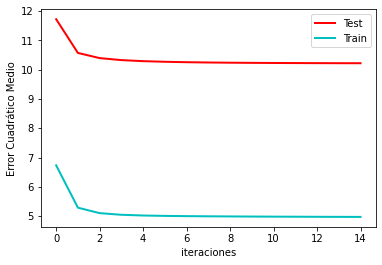

In [12]:
plt.plot(als.test_ecm_record, label = 'Test', linewidth = 2,color='r')
plt.plot(als.train_ecm_record, label = 'Train', linewidth = 2,color='c')
plt.xlabel('iteraciones')
plt.ylabel('Error Cuadrático Medio')
plt.legend(['Test','Train'])
plt.show()

Observamos que con muy pocas iteraciones el ECM baja, por lo que en las siguientes evaluaciones utilizaremos 15 iteraciones.

### Cross Validation

Ahora realizamos el método de Cross Validation para obtener la mejor k.

In [13]:
n_folds = 5

In [14]:
K_list = [10,71,171,271,371,471,571,671]

In [18]:
#K_list = []
#for i in range(1, train.shape[0], 10):
#for i in range(1, train.shape[0], 100):
#    K_list.append(i)

In [15]:
df_k = pd.DataFrame(0.0, index=range(1), columns=K_list)
data = train

In [16]:
data.shape

(671, 9125)

In [38]:
# Dividimos los datos en chunk de igual tamaño de forma vertical
chunks = np.hsplit(data, n_folds)
for k in K_list:
    error = 0.0
    for i in range(1, int(n_folds)):

        # El chunk i será nuestro bloque de datos de prueba
        test_data = chunks[i]

        # Entrenamos con todos los otros datos menos con el chunk[i]
        train_data = chunks.copy()
        train_data.pop(i)
        train_data = np.concatenate(train_data)
        
        als = Matrix_Factorization(n_iters = 15, k = k, _lambda = 0.01)
        als.fit(train_data, test_data)
        error += np.mean(als.train_ecm_record)
    error /= n_folds

    df_k[k][0] = error

df_k

,10,71,171,271,371,471,571,671
0,5.971187,3.608011,1.974854,1.134838,0.659502,0.382173,0.218404,0.122604


In [39]:
K_list=np.array(K_list)

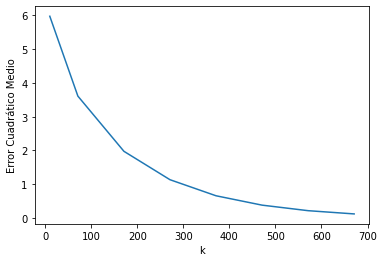

In [40]:
plt.plot(K_list,df_k.iloc[0])
plt.xlabel('k')
plt.ylabel('Error Cuadrático Medio')
plt.show()
plt.show()

## Validación

Una vez elegido el modelo realizaremos la validación: 

In [17]:
k_optima = 280

als = Matrix_Factorization(n_iters = 15, k = k_optima, _lambda = 0.01)
als.fit(train, test)

In [18]:
# Esta es la matriz completa para poder hacer recomendaciones
MCompleta = als.predict()
MCompleta = pd.DataFrame(MCompleta, 
                         columns=ratings.columns, 
                         index=ratings.index)

## Recomendaciones

In [19]:
id_user = 3

In [20]:
rec_nvas, rec_todas = recomendaciones_id(np.array(ratings)[id_user-1], 
                                         np.array(MCompleta)[id_user-1], 
                                         arr_movies, 
                                         bases_nombres_id, 
                                         id_user)

In [21]:
# Películas recomendadas que no ha visto
print("Estás son las nuevas películas que te recomendamos usuario no. ", id_user)
bases_nombres_id[bases_nombres_id['movieId'].isin(rec_nvas)][["movieId", "title"]]

Estás son las nuevas películas que te recomendamos usuario no.  3


,movieId,title
34,2329,American History X
61,1270,Back to the Future
194,33794,Batman Begins
3363,2770,Bowfinger
6655,380,True Lies


In [22]:
# Películas recomendadas que probablemente ya vio
print("Estás películas te pueden interesar usuario no. ", id_user)
bases_nombres_id[bases_nombres_id['movieId'].isin(rec_todas)][["movieId", "title"]]

Estás películas te pueden interesar usuario no.  3


,movieId,title
5,356,Forrest Gump
200,318,The Shawshank Redemption
361,2959,Fight Club
477,296,Pulp Fiction
1206,1197,The Princess Bride


In [23]:
# Probemos para el usuario 1
desempenio_NDCG(ratings, id_user)

0.29

#### Obtengamos  el desempeño para todos los usuarios

In [24]:
ndcg = obtain_ndcg_all_users(MCompleta)

In [30]:
ndcg_Y_0 = obtain_ndcg_all_users(ratings)

In [29]:
for x in list(ndcg)[0:8]:
    print ("user: {} - ndcg: {}".format(x, ndcg[x]))

user: 1 - ndcg: 1.3
user: 2 - ndcg: 0.53
user: 3 - ndcg: 0.62
user: 4 - ndcg: 0.21
user: 5 - ndcg: 0.36
user: 6 - ndcg: 0.9
user: 7 - ndcg: 0.46
user: 8 - ndcg: 0.33


In [31]:
for x in list(ndcg_Y_0)[0:8]:
    print ("user: {} - ndcg: {}".format(x, ndcg_Y_0[x]))

user: 1 - ndcg: 0.43
user: 2 - ndcg: 0.27
user: 3 - ndcg: 0.29
user: 4 - ndcg: 0.19
user: 5 - ndcg: 0.26
user: 6 - ndcg: 0.27
user: 7 - ndcg: 0.29
user: 8 - ndcg: 0.24


In [32]:
ndcg_a = list(ndcg. items())
ndcg_ar = np.array(ndcg_a)

In [33]:
ndcg_ar.shape

(671, 2)

In [34]:
ndcg_Y_0_a = list(ndcg_Y_0.items())
ndcg_Y_0_ar = np.array(ndcg_Y_0_a)

In [35]:
ndcg_Y_0_ar.shape

(671, 2)

In [36]:
np.testing.assert_allclose(ndcg_ar[:,1], ndcg_Y_0_ar[:,1], atol=0.01, rtol=0.01)

AssertionError: 
Not equal to tolerance rtol=0.01, atol=0.01

Mismatched elements: 558 / 671 (83.2%)
Max absolute difference: 1.1
Max relative difference: 5.35
 x: array([1.3 , 0.53, 0.62, 0.21, 0.36, 0.9 , 0.46, 0.33, 0.52, 0.83, 0.76,
       1.05, 0.44, 1.09, 0.34, 0.65, 0.24, 0.67, 0.29, 0.38, 0.35, 0.32,
       0.28, 0.65, 1.  , 0.29, 0.71, 0.6 , 1.01, 0.25, 0.41, 0.57, 0.33,...
 y: array([0.43, 0.27, 0.29, 0.19, 0.26, 0.27, 0.29, 0.24, 0.25, 0.25, 0.22,
       0.31, 0.26, 0.36, 0.33, 0.23, 0.23, 0.32, 0.28, 0.27, 0.3 , 0.29,
       0.27, 0.26, 0.32, 0.26, 0.23, 0.19, 0.25, 0.25, 0.23, 0.26, 0.29,...